In [15]:


#Импорты и функции

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from copy import deepcopy

# Функция для обрезки линии в границы изображения
def clip_line_to_image(pt1, pt2, img_shape):
    h, w = img_shape[:2]
    ret, clipped_pt1, clipped_pt2 = cv2.clipLine((0, 0, w, h), pt1, pt2)
    if ret:
        return clipped_pt1, clipped_pt2
    else:
        return pt1, pt2



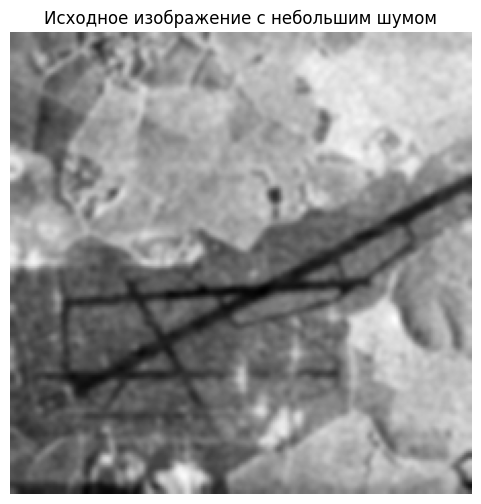

In [16]:
# Загрузка изображения и предобработка
image = cv2.imread('sar_3.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Размытие для снижения шума
blurred = cv2.GaussianBlur(image_gray, (7, 7), 0)

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap='gray')
plt.title("Исходное изображение с небольшим шумом")
plt.axis('off')
plt.show()


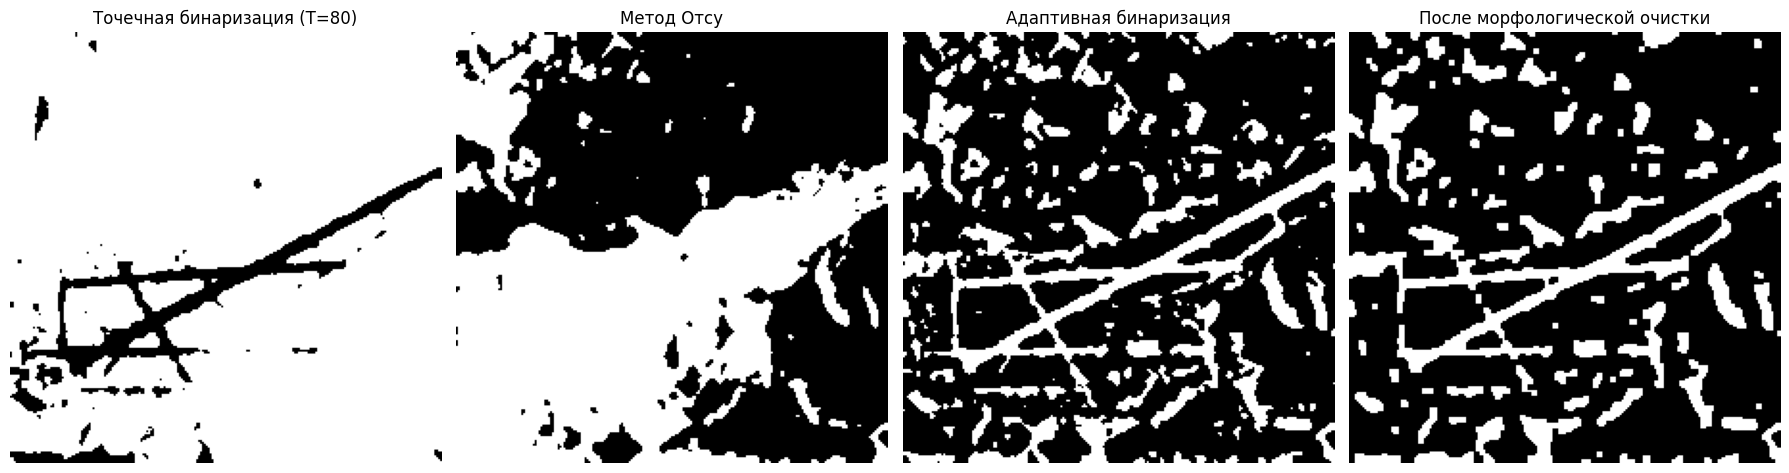

In [17]:
# бинаризация

plt.figure(figsize=(18, 5))

# 1. Точечная бинаризация
T_value = 80
binary_manual = deepcopy(blurred)
binary_manual[blurred < T_value] = 0
binary_manual[blurred >= T_value] = 255
plt.subplot(1,4,1)
plt.imshow(binary_manual, cmap='gray')
plt.title(f"Точечная бинаризация (T={T_value})")
plt.axis('off')

# 2. Бинаризация по Отсу
_, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.subplot(1,4,2)
plt.imshow(binary_otsu, cmap='gray')
plt.title("Метод Отсу")
plt.axis('off')

# 3. Адаптивная бинаризация
binary_adaptive = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 51, 10
)
plt.subplot(1,4,3)
plt.imshow(binary_adaptive, cmap='gray')
plt.title("Адаптивная бинаризация")
plt.axis('off')

# 4. Финальный выбор: адаптивная бинаризация + морфология
kernel = np.ones((3,3), np.uint8)
binary_clean = cv2.morphologyEx(binary_adaptive, cv2.MORPH_OPEN, kernel)
binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel)
plt.subplot(1,4,4)
plt.imshow(binary_clean, cmap='gray')
plt.title("После морфологической очистки")
plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:


# Детекция границ и преобразование Хафа

edges = cv2.Canny(binary_clean, 50, 150)

# HoughLines (классический)
lines_basic = cv2.HoughLines(edges, 1, np.pi/180, 120)

# HoughLinesP (вероятностный)
lines_prob = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=20)

# Визуализация всех линий и поиск самой длинной
image_hough = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
max_length_basic = 0
longest_line_basic = None

if lines_basic is not None:
    for i in range(len(lines_basic)):
        rho, theta = lines_basic[i][0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a*rho
        y0 = b*rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pt1, pt2 = clip_line_to_image(pt1, pt2, image.shape)
        length = np.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)
        if length > max_length_basic:
            max_length_basic = length
            longest_line_basic = (pt1, pt2)
        cv2.line(image_hough, pt1, pt2, (0,255,0), 1)

# Вероятностный Хафф: самая длинная линия
max_length_prob = 0
longest_line_prob = None
image_hough_prob = image.copy()
if lines_prob is not None:
    for line in lines_prob:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        if length > max_length_prob:
            max_length_prob = length
            longest_line_prob = line
        cv2.line(image_hough_prob, (x1,y1), (x2,y2), (0,255,0), 1)

# Отметим самую длинную линию красным
if longest_line_basic is not None:
    cv2.line(image_hough, longest_line_basic[0], longest_line_basic[1], (0,0,255), 3)
if longest_line_prob is not None:
    x1,y1,x2,y2 = longest_line_prob[0]
    cv2.line(image_hough_prob, (x1,y1), (x2,y2), (0,0,255), 3)

In [19]:

# Поиск протяженного участка через контуры
contours, _ = cv2.findContours(binary_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour_length = 0
longest_contour = None
for cnt in contours:
    length = cv2.arcLength(cnt, False)
    if length > max_contour_length:
        max_contour_length = length
        longest_contour = cnt

image_contour = image.copy()
if longest_contour is not None:
    cv2.drawContours(image_contour, [longest_contour], -1, (0,0,255), 3)

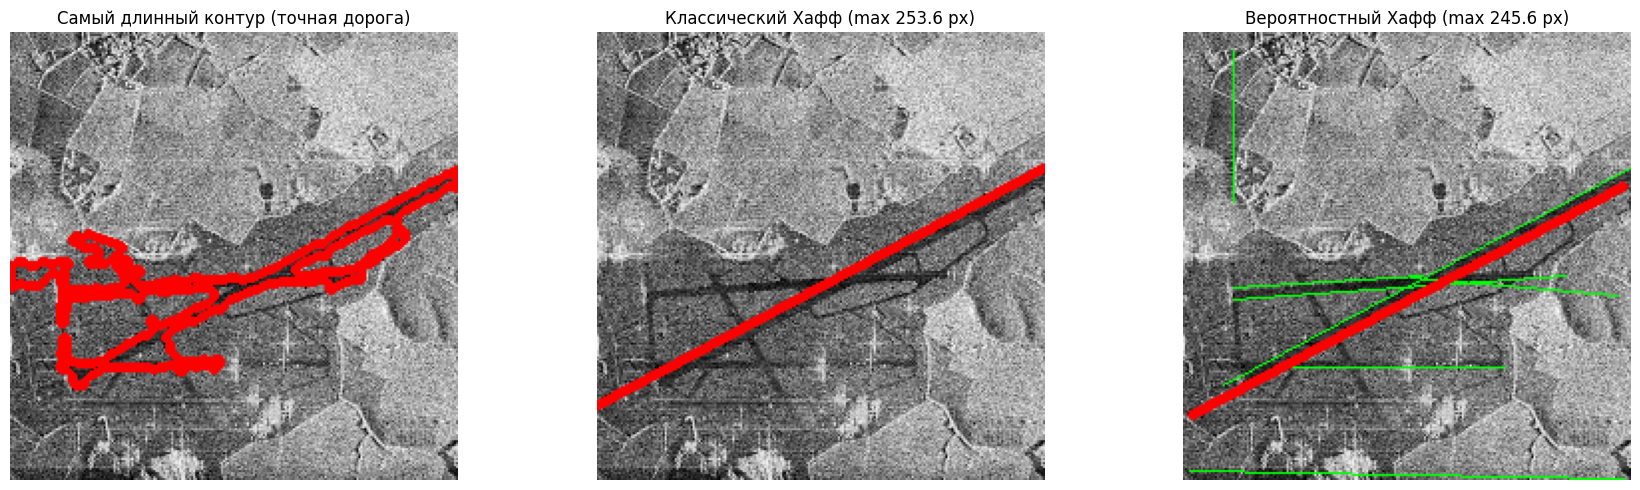

In [20]:

# Б Визуализация

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
plt.title("Самый длинный контур (точная дорога)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(image_hough, cv2.COLOR_BGR2RGB))
plt.title(f"Классический Хафф (max {max_length_basic:.1f} px)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(image_hough_prob, cv2.COLOR_BGR2RGB))
plt.title(f"Вероятностный Хафф (max {max_length_prob:.1f} px)")
plt.axis('off')

plt.tight_layout()
plt.show()



In [21]:

#  Сравнительный анализ

print("=== СРАВНЕНИЕ ДЛИН ЛИНИЙ И КОНТУРОВ ===")
print(f"Длина самого длинного контура: {max_contour_length:.1f} px")
print(f"Длина самой длинной линии классического Хаффа: {max_length_basic:.1f} px")
print(f"Длина самой длинной линии вероятностного Хаффа: {max_length_prob:.1f} px")

# Сравнение методов бинаризации по проценту пикселей дороги
methods = {
    "Точечная бинаризация": binary_manual,
    "Метод Отсу": binary_otsu,
    "Адаптивная": binary_adaptive
}

print("\n=== АНАЛИЗ БИНАРИЗАЦИИ ===")
for name, img_bin in methods.items():
    road_pixels = np.sum(img_bin > 0)
    total_pixels = img_bin.size
    perc = road_pixels / total_pixels * 100
    print(f"{name}: {perc:.1f}% пикселей дороги")



=== СРАВНЕНИЕ ДЛИН ЛИНИЙ И КОНТУРОВ ===
Длина самого длинного контура: 1162.2 px
Длина самой длинной линии классического Хаффа: 253.6 px
Длина самой длинной линии вероятностного Хаффа: 245.6 px

=== АНАЛИЗ БИНАРИЗАЦИИ ===
Точечная бинаризация: 91.7% пикселей дороги
Метод Отсу: 46.4% пикселей дороги
Адаптивная: 23.4% пикселей дороги
